In [2]:
import pickle as pkl
import numpy as np
import pandas as pd

try:
    df  = pd.read_csv("counts_df.csv")
    df0 = pd.read_csv("counts_df_baseline.csv")
except IOError:
    
    print "IOError"

    with open("test_know_dist_T5.0_beta0.05.pkl","rb") as f:
        tst, tst_n_boxes, tst_scores = pkl.load(f)

    tst = tst.astype(float)

    df = pd.DataFrame({
        'counts':tst,
        'log_counts':np.log(1+tst),
        'n_boxes':tst_n_boxes,
        'pixels_above':tst_scores,
    })

    df.to_csv("counts_df.csv", index=False)
    
    with open("test_baseline.pkl","rb") as f:
        tst_base, tst_n_boxes_base, tst_scores_base = pkl.load(f)

    tst_base = tst_base.astype(float)

    df0 = pd.DataFrame({
        'counts':tst_base,
        'log_counts':np.log(1+tst_base),
        'n_boxes':tst_n_boxes_base,
        'pixels_above':tst_scores_base,
    })

    df0.to_csv("counts_df_baseline.csv", index=False)

In [3]:
df.head(10)

,counts,log_counts,n_boxes,pixels_above
0,1.0,0.693147,0,0.0
1,2.0,1.098612,2,1459.0
2,5.0,1.791759,6,6878.0
3,1.0,0.693147,6,2382.0
4,1.0,0.693147,6,5811.0
5,6.0,1.945910,6,7385.0
6,2.0,1.098612,6,6595.0
7,2.0,1.098612,2,1056.0
8,1.0,0.693147,4,2366.0
9,1.0,0.693147,4,2225.0


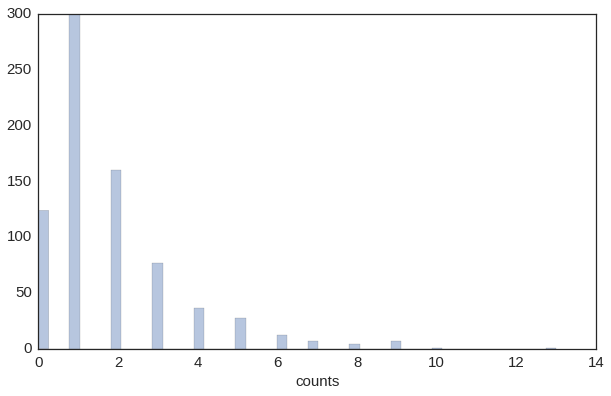

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

sns.set_style("white")

plt.rcParams['figure.figsize'] = (10, 6)

plt.rcParams['xtick.labelsize'] = 15
plt.rcParams['ytick.labelsize'] = 15
plt.rcParams['axes.labelsize']  = 15

ax = sns.distplot(df.counts, kde=False)


To test how well the model performes while counting the number of people in an image we test the model a total of one thousand times. In each of these iterations we split the data-set in half (a training and a testing half) and train a gradient boosting regressor based with a simple linear model as its base learner.

In [81]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import precision_recall_fscore_support
from xgboost import XGBRegressor as XGB

#data = {"value_{0}".format(i):[] for i in range(7)}
#data["metric"] =  []
#data["model"]  =  []

data = {"score":[], "metric":[], "model":[], "people count":[]}

R2 = []


for mod, dframe in [("baseline", df0), ("knowledge distillation", df)]:
    
    r2, f1, pre, rec, = np.empty(shape=(0,7)), np.empty(shape=(0,7)), np.empty(shape=(0,7)), np.empty(shape=(0,7))
    for _ in range(1000):

        reg  = XGB(
            max_depth=1,
            learning_rate=0.3,
            n_estimators=35
        )

        X_trn, X_tst, y_trn, y_tst = train_test_split(
            dframe[['n_boxes','pixels_above']],
            dframe.log_counts,
            test_size=0.5,
        )

        reg.fit(X_trn, y_trn)

        y_true, y_pred = np.exp(y_tst), np.exp(reg.predict(X_tst))

        R2.append(r2_score(y_true, y_pred))

        precision, recall, f_score, _ = precision_recall_fscore_support(
            y_true.astype(int),
            np.round(y_pred).astype(int),
        )
        
        for metric, score in \
        [("Precision", precision), ("Recall", recall), ("F1 Score", f_score)]:
        
            #data["metric"].append(metric)
            #data["model"].append(mod)
            
            #for i in range(7):
            #    data["value_{0}".format(i)].append(value[i])
            
            for i in range(6):
                data["metric"].append(metric)
                data["model"].append(mod)
                data["score"].append(score[i])
                data["people count"].append(i)
                
    print "R2 Score", np.mean(R2)

R2 Score 0.439135509465
R2 Score 0.508699807556


In [82]:
table = pd.DataFrame(data)

table.head()

,metric,model,people count,score
0,Precision,baseline,0,0.810811
1,Precision,baseline,1,0.539773
2,Precision,baseline,2,0.238938
3,Precision,baseline,3,0.333333
4,Precision,baseline,4,0.000000


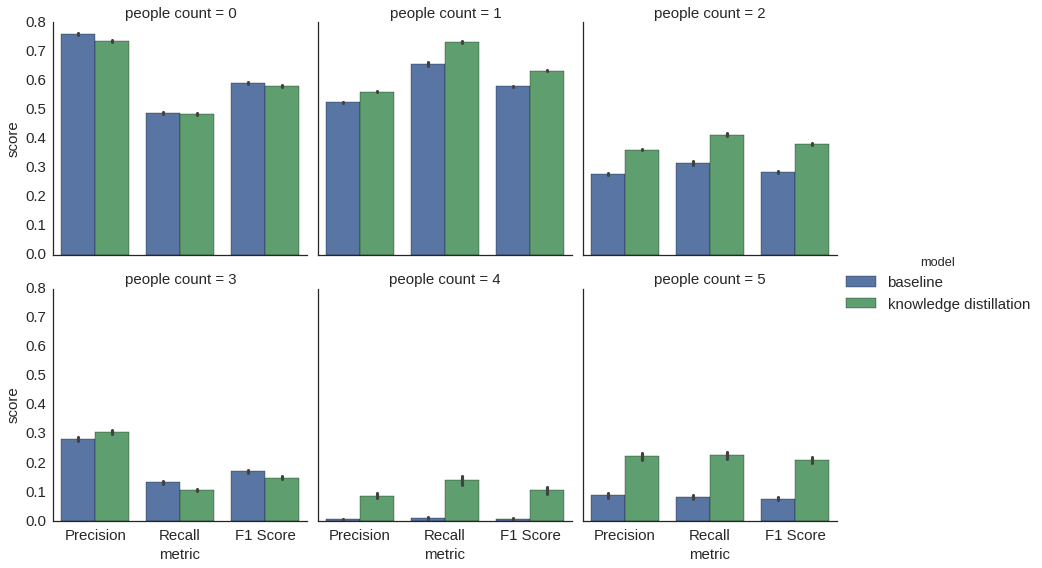

In [83]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

sns.set_style("white")

plt.rcParams['xtick.labelsize'] = 15
plt.rcParams['ytick.labelsize'] = 15
plt.rcParams['axes.labelsize']  = 15
plt.rcParams['legend.fontsize'] = 15

sns.factorplot(
    x="metric",
    y="score",
    hue="model",
    col="people count",
    data=table,
    kind="bar",
    col_wrap=3,
)